In [1]:
!pip install nibabel
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# import dicom2nifti
import numpy as np
import nibabel as nib
import nilearn as nil
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.ndimage import zoom, gaussian_filter

# Inspecting NIfTI file

In [3]:
def show_nifti_grid(path,rows,cols):
    nifti_vol = nib.load(path)
    nifti_vol_data = nifti_vol.get_fdata()

    n_subplots = rows * cols
    n_slice = nifti_vol_data.shape[2]
    step_size = n_slice // n_subplots
    plot_range = n_subplots * step_size
    start_stop = int((n_slice - plot_range) / 2)
    
    fig, axs = plt.subplots(rows, cols, figsize=[10, 10])
    
    for idx, img in enumerate(range(start_stop, plot_range, step_size)):
        axs.flat[idx].imshow(ndi.rotate(nifti_vol_data[:, :, img], 90), cmap='gray')
        axs.flat[idx].axis('off')
            
    plt.tight_layout(pad=-3.0)
    plt.show()

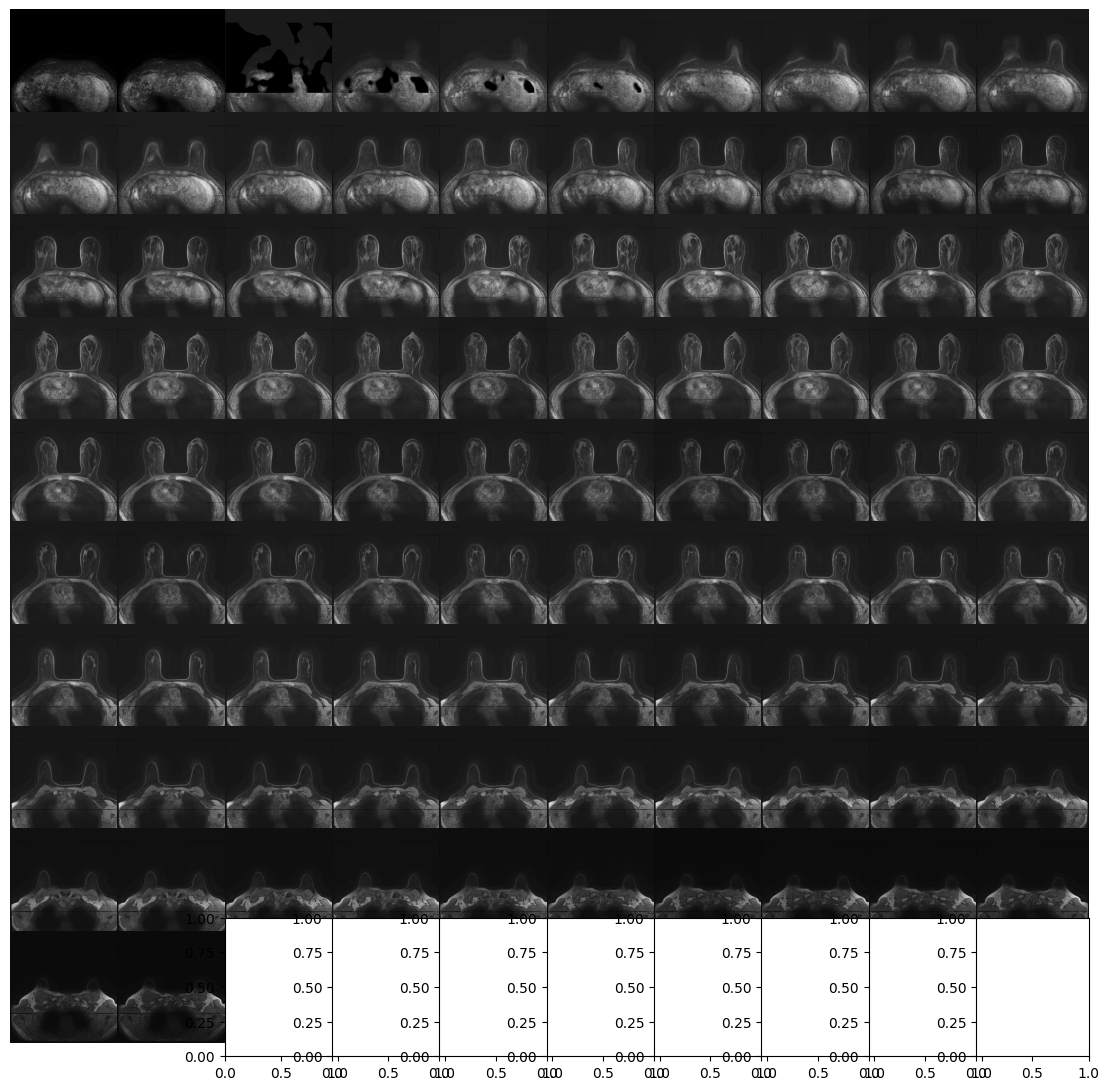

In [4]:
show_nifti_grid('image_files/test_patient/p_001.nii.gz',10,10)

# Generating augmented NIfTI files

In [5]:
def load_nifti(file_path):
    return nib.load(file_path)

def save_nifti(data, header, file_path):
    new_img = nib.Nifti1Image(data, None, header)
    new_img.to_filename(file_path)

def apply_transformations(image_data, factor_width, factor_height, blur_size, file_number, num_files):
    # Apply zoom transformation only to width and height, not depth
    transformed_data = zoom(image_data, (factor_width, factor_height, 1), order=1, mode='constant', cval=0)
    
    # Calculate the sigma for Gaussian blur
    t = np.linspace(0, 2 * np.pi, num_files+1)[file_number]
    sigma = 0 + (blur_size * np.abs(np.sin(t)))
    
    # Apply Gaussian blur
    transformed_data = gaussian_filter(transformed_data, sigma=(sigma*.25, sigma, 0))
    
    return transformed_data

def calculate_max_dimensions(data_shape, factors_width, factors_height):
    dimensions = [(int(np.ceil(data_shape[0] * fw)), 
                   int(np.ceil(data_shape[1] * fh)), 
                   data_shape[2]) for fw, fh in zip(factors_width, factors_height)]
    max_dims = np.max(dimensions, axis=0)
    return max_dims

def pad_to_max_dimensions(image_data, max_dims):
    # Ensure max_dims are at least as large as image_data dimensions
    if any(md < i_d for md, i_d in zip(max_dims, image_data.shape)):
        raise ValueError(f"Error: max_dims {max_dims} must be greater than or equal to image_data dimensions {image_data.shape}.")
        
    padded_data = np.zeros(max_dims, dtype=image_data.dtype)
    w_offset = (max_dims[0] - image_data.shape[0]) // 2
    h_offset = 0 #vertically, the image is at the bottom
    d_offset = (max_dims[2] - image_data.shape[2]) // 2

    padded_data[w_offset:w_offset + image_data.shape[0],
                h_offset:h_offset + image_data.shape[1],
                d_offset:d_offset + image_data.shape[2]] = image_data
    return padded_data

def get_filename(path, extension = '.nii.gz'):
    idx1 = path.rfind('/')
    idx2 = path.index(extension)
    return path[idx1 + 1: idx2]

def generate_transformed_niftis(input_path, output_path, num_files=5, max_elongation=0.15, blur_size=5):
    nifti_img = load_nifti(input_path)
    data = nifti_img.get_fdata()
    header = nifti_img.header 
    filename = get_filename(input_path)
    
    factors_width = 1.0 + max_elongation * np.sin(np.linspace(0, 2 * np.pi, num_files)) * 0.25
    factors_height = 1.0 + max_elongation * np.sin(np.linspace(0, 2 * np.pi, num_files))

    max_dims = calculate_max_dimensions(data.shape, factors_width, factors_height)


    for i in range(num_files):
        factor_w = factors_width[i]
        factor_h = factors_height[i]
        transformed_data = apply_transformations(data, factor_w, factor_h, blur_size, i, num_files)  # Scale width, height, and apply Gaussian blur
        padded_data = pad_to_max_dimensions(transformed_data, max_dims)
        save_nifti(padded_data, header, f"{output_path}/{filename}_t_{i}.nii.gz")

In [6]:
num_files = 5

input_path = 'image_files/test_patient/p_001.nii.gz'
output_path = 'image_files/test_patient/augmented_nifti_files/mri/'

generate_transformed_niftis(input_path, output_path, num_files)

# Show augmented NIfTIs

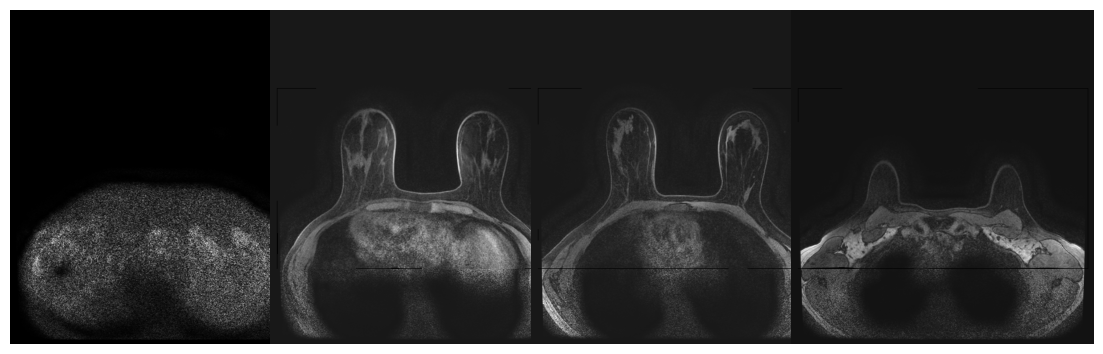

In [7]:
filename = get_filename(input_path)

show_nifti_grid(f'image_files/test_patient/augmented_nifti_files/mri/{filename}_t_0.nii.gz',1,4)

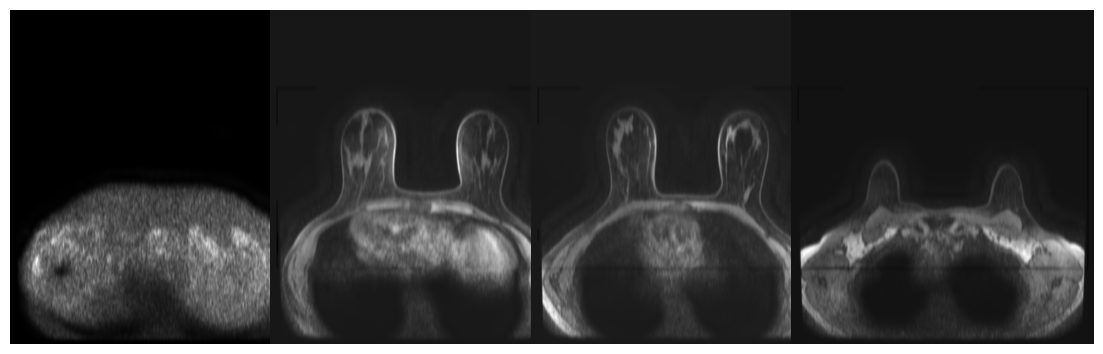

In [8]:
show_nifti_grid(f'image_files/test_patient/augmented_nifti_files/mri/{filename}_t_2.nii.gz',1,4)

In [9]:
def display_slices(filenames, slice_index):
    """
    Display the same slice index for all given NIfTI files side by side.
    
    :param filenames: List of paths to the NIfTI files.
    :param slice_index: Index of the slice to display.
    """
    # Load all images
    images = [nib.load(filename) for filename in filenames]
    
    # Extract data from images
    slices = [img.get_fdata()[:, :, slice_index] for img in images]
    
    # Plot slices
    num_slices = len(slices)
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))
    
    if num_slices == 1:
        axes = [axes]
        
    for i, slice_data in enumerate(slices):
        axes[i].imshow(slice_data.T, cmap="gray", origin="lower")
        # axes[i].set_title(f'Slice from {filenames[i]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

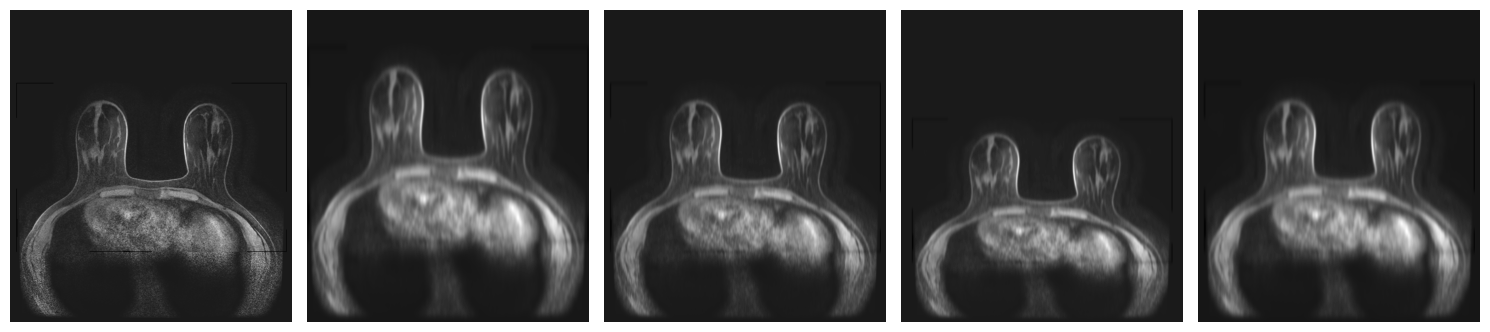

In [11]:
folder_path = 'image_files/test_patient/augmented_nifti_files/mri/'
filenames = [folder_path+f'{filename}_t_{i}.nii.gz' for i in range(num_files)]
slice_index = 30  # Adjust this index as needed
display_slices(filenames, slice_index)

# Segmentation augmentation

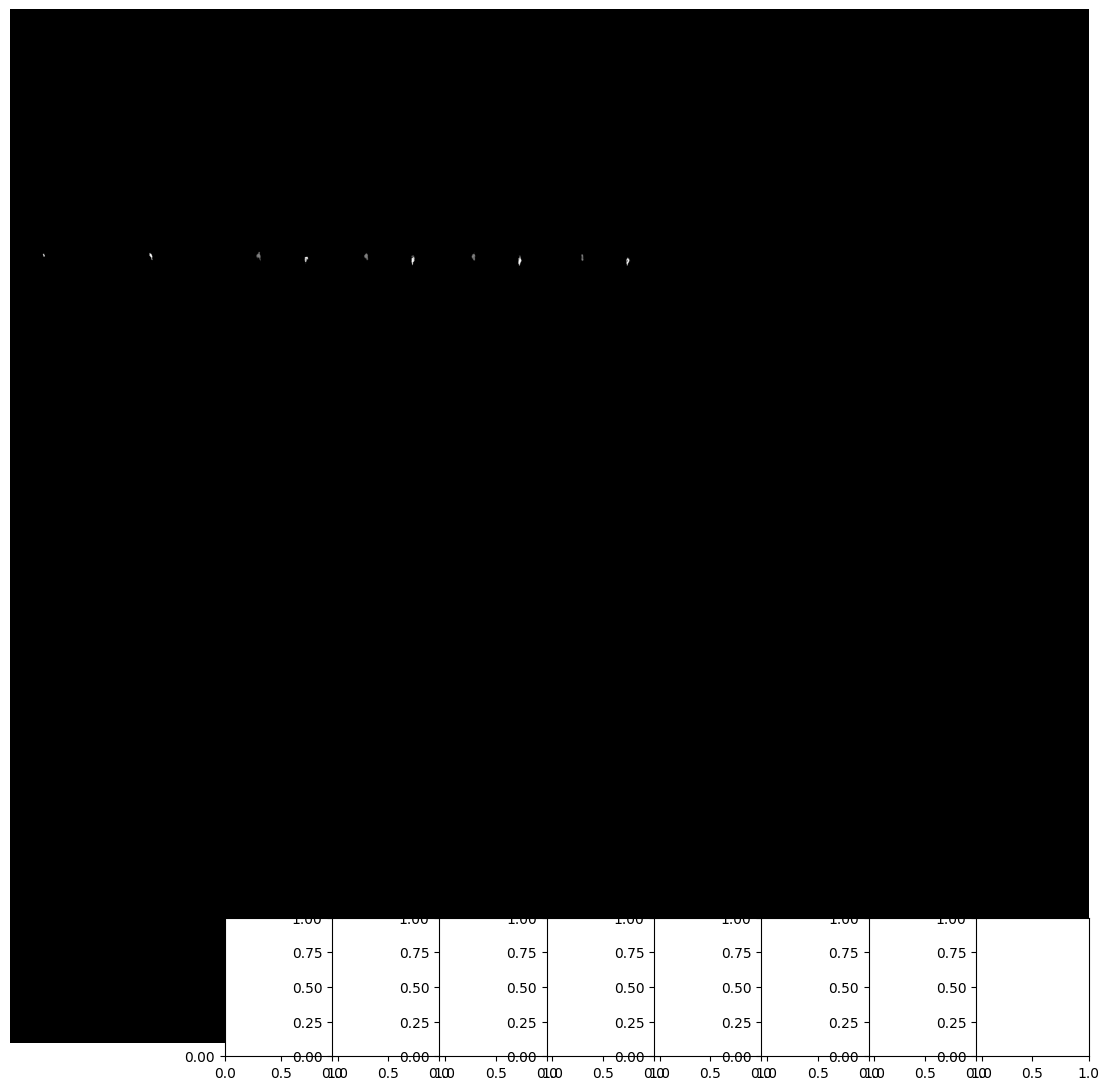

In [12]:
show_nifti_grid('image_files/test_patient/p_001_ROI.nii.gz',10,10)

In [13]:
num_files = 5

input_path = 'image_files/test_patient/p_001_ROI.nii.gz'
output_path = 'image_files/test_patient/augmented_nifti_files/seg/'
filename = get_filename(input_path)

generate_transformed_niftis(input_path, output_path, num_files, blur_size=0) #blur_size=0 is VERY IMPORTANT with the segmentation file

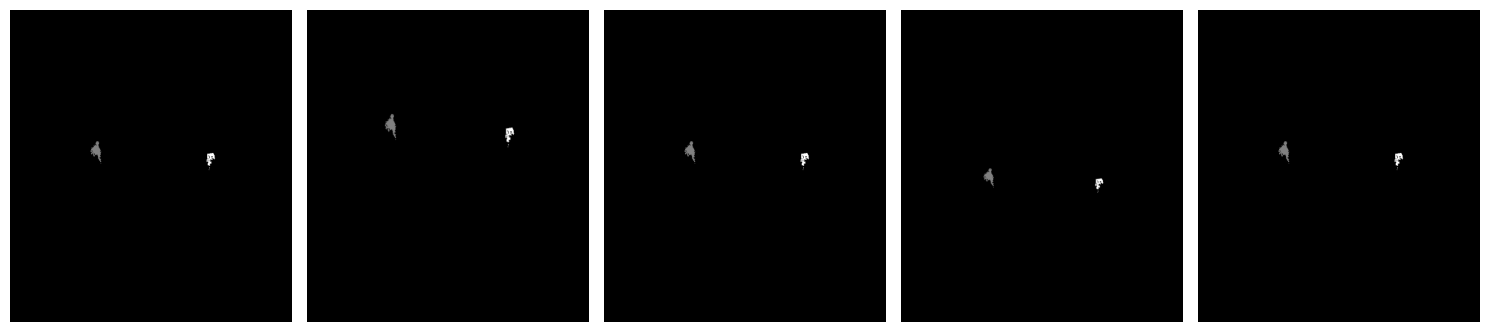

In [14]:
folder_path = 'image_files/test_patient/augmented_nifti_files/seg/'
filenames = [folder_path+f'{filename}_t_{i}.nii.gz' for i in range(num_files)]
slice_index = 30  # Adjust this index as needed
display_slices(filenames, slice_index)